### Stuff to add:
- Function to generate `vasp_std` chemical potential relaxation files, given input converged k-points.
- Note about cost of `vasp_ncl` chemical potential calculations for metals, use `ISMEAR = -5`, possibly `NKRED` etc. (make a function to generate `vasp_ncl` calculation files with `ISMEAR = -5`, with option to set different kpoints)
- Add `defects_std_to_ncl.sh` bash script to auto-generate non-symmetrised `KPOINTS` for SOC `vasp_ncl` run from `vasp_std` IBZKPT, and copy `vasp_std/CONTCAR` to `vasp_ncl/POSCAR`, copy `CHGCAR`, `POTCAR` over etc.
- Add `chempot_std_to_ncl.sh` bash script to auto-generate non-symmetrised `KPOINTS` for SOC `vasp_ncl` run (note on editing `module load vasp` command), and copy `vasp_std/CONTCAR` to `vasp_ncl/POSCAR`, copy `CHGCAR`, `POTCAR` over etc.
- Use `UserChemPotAnalyzer` to parse chemical potential calculations

# DefectsWithTheBoys Example Workbook

In [1]:
from DefectsWithTheBoys import vasp_input
from DefectsWithTheBoys.pycdt.core.defectsmaker import ChargedDefectsStructures
from pymatgen.core.structure import Structure

In [2]:
# Specify perfect (bulk) supercell structure
perfect_supercell = Structure.from_file(
    'Examples/perfect_supercell_POSCAR')  # CdTe

# Note that we've modified PyCDT's ChargedDefectStructures, so that it uses Voronoi interstitial generation
# algorithm (crashes with the other, default algorithm...)
# and got rid of the deprecated str2unicode function. We've also removed "Voronoi" and "mult_XX" from the
# interstitial name (too much crap in the names...)
def_structs = ChargedDefectsStructures(
    perfect_supercell, cellmax=perfect_supercell.num_sites,
    substitutions={"Te": ["Se"]}, # As a dictionary 
    antisites_flag=True, max_min_oxi=None, # max_min_oxi for bulk elements only unfortunately (not substitutions)
    include_interstitials=True, interstitial_elements=['Cd', 'Te'])

Setting up defects...
Searching for Voronoi interstitial sites (this can take awhile)...

Number of jobs created:
    bulk = 1
    vacancies:
        vac_1_Cd = 5 with site multiplicity 32
        vac_2_Te = 5 with site multiplicity 32
    substitutions:
        sub_2_Se_on_Te = 7 with site multiplicity 32
        as_1_Cd_on_Te = 7 with site multiplicity 32
        as_1_Te_on_Cd = 7 with site multiplicity 32
    interstitials:
        Int_Cd_1 = 3 with site multiplicity 32
        Int_Cd_2 = 3 with site multiplicity 128
        Int_Cd_3 = 3 with site multiplicity 1
        Int_Te_1 = 9 with site multiplicity 1
        Int_Te_2 = 9 with site multiplicity 128
        Int_Te_3 = 9 with site multiplicity 32
Total (non dielectric) jobs created = 68



In [8]:
# Expand the output of this cell to see what the ChargedDefectsStructures output
# dictionary looks like #noblackboxesherepal
print(def_structs.defects)

{'bulk': {'name': 'bulk', 'supercell': {'size': [1, 1, 1], 'structure': Structure Summary
Lattice
    abc : 13.086768 13.086768 13.086768
 angles : 90.0 90.0 90.0
 volume : 2241.2856479961474
      A : 13.086768 0.0 0.0
      B : 0.0 13.086768 0.0
      C : 0.0 0.0 13.086768
PeriodicSite: Cd (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Cd (0.0000, 0.0000, 6.5434) [0.0000, 0.0000, 0.5000]
PeriodicSite: Cd (0.0000, 6.5434, 0.0000) [0.0000, 0.5000, 0.0000]
PeriodicSite: Cd (0.0000, 6.5434, 6.5434) [0.0000, 0.5000, 0.5000]
PeriodicSite: Cd (6.5434, 0.0000, 0.0000) [0.5000, 0.0000, 0.0000]
PeriodicSite: Cd (6.5434, 0.0000, 6.5434) [0.5000, 0.0000, 0.5000]
PeriodicSite: Cd (6.5434, 6.5434, 0.0000) [0.5000, 0.5000, 0.0000]
PeriodicSite: Cd (6.5434, 6.5434, 6.5434) [0.5000, 0.5000, 0.5000]
PeriodicSite: Cd (0.0000, 3.2717, 3.2717) [0.0000, 0.2500, 0.2500]
PeriodicSite: Cd (0.0000, 3.2717, 9.8151) [0.0000, 0.2500, 0.7500]
PeriodicSite: Cd (0.0000, 9.8151, 3.2717) [0.0000, 0.7

In [3]:
vacancies_only = {'vacancies': [
    val for val in def_structs.defects['vacancies']]}
substitutions_only = {'substitutions': [
    val for val in def_structs.defects['substitutions']]}
interstitials_only = {'interstitials': [
    val for val in def_structs.defects['interstitials']]}

In [4]:
# Look at the PyCDT-proposed likely defect charge states, and think if ya wanna change it
for val in substitutions_only['substitutions']:
    print(f"Defect: {val['name']}")
    print(f"PyCDT-proposed defect charge states: {val['charges']}")
    print("Happy with this? If not look at the next code block yeh \n")

Defect: sub_2_Se_on_Te
PyCDT-proposed defect charge states: [-1, 0, 1, 2, 3, 4, 5]
Happy with this? If not look at the next code block yeh 

Defect: as_1_Cd_on_Te
PyCDT-proposed defect charge states: [-2, -1, 0, 1, 2, 3, 4]
Happy with this? If not look at the next code block yeh 

Defect: as_1_Te_on_Cd
PyCDT-proposed defect charge states: [-2, -1, 0, 1, 2, 3, 4]
Happy with this? If not look at the next code block yeh 



In [5]:
# Can manually set the charge states you want to investigate, if the auto-generated ones from PyCDT
# (using observed oxidatation states) aren't the exact range you want to calculate
for val in substitutions_only['substitutions']:
    if val['name'] == 'as_1_Cd_on_Te':
        val['charges'] = [0, 1, 2]
    elif val['name'] == 'as_1_Te_on_Cd':
        val['charges'] = [-2, -1, 0]
for val in interstitials_only['interstitials']:
    if val['site_specie'] == 'Te':
        val['charges'] = [-2, -1, 0]
for val in vacancies_only['vacancies']:
    if val['site_specie'] == 'Cd':
        val['charges'] = [-2, -1, 0]
    elif val['site_specie'] == 'Te':
        val['charges'] = [0, 1, 2]

In [6]:
# Look at the new range of defect charge states
for val in substitutions_only['substitutions']:
    print(f"Defect: {val['name']}")
    print(f"New defect charge states: {val['charges']}\n")

Defect: sub_2_Se_on_Te
New defect charge states: [-1, 0, 1, 2, 3, 4, 5]

Defect: as_1_Cd_on_Te
New defect charge states: [0, 1, 2]

Defect: as_1_Te_on_Cd
New defect charge states: [-2, -1, 0]



In [9]:
cdte_vacancies = vasp_input.prepare_vasp_defect_inputs(vacancies_only)
# Generates a dictionary of folders for VASP defect calculations
# Can do the same with the substitutions and interstitials with:
# cdte_substitutions = prepare_vasp_defect_inputs(substitutions_only)
# cdte_interstitials = prepare_vasp_defect_inputs(interstitials_only)

vac_1_Cd_-2
vac_1_Cd_-1
vac_1_Cd_0
vac_2_Te_0
vac_2_Te_1
vac_2_Te_2


In [10]:
cdte_vacancies  # Expand the output of this cell to see what the prepare_vasp_defect_inputs output
# dictionary looks like #noblackboxesherepal

{'vac_1_Cd_-2': {'Defect Structure': Structure Summary
  Lattice
      abc : 13.086768 13.086768 13.086768
   angles : 90.0 90.0 90.0
   volume : 2241.2856479961474
        A : 13.086768 0.0 0.0
        B : 0.0 13.086768 0.0
        C : 0.0 0.0 13.086768
  PeriodicSite: Cd (0.0000, 0.0000, 6.5434) [0.0000, 0.0000, 0.5000]
  PeriodicSite: Cd (0.0000, 6.5434, 0.0000) [0.0000, 0.5000, 0.0000]
  PeriodicSite: Cd (0.0000, 6.5434, 6.5434) [0.0000, 0.5000, 0.5000]
  PeriodicSite: Cd (6.5434, 0.0000, 0.0000) [0.5000, 0.0000, 0.0000]
  PeriodicSite: Cd (6.5434, 0.0000, 6.5434) [0.5000, 0.0000, 0.5000]
  PeriodicSite: Cd (6.5434, 6.5434, 0.0000) [0.5000, 0.5000, 0.0000]
  PeriodicSite: Cd (6.5434, 6.5434, 6.5434) [0.5000, 0.5000, 0.5000]
  PeriodicSite: Cd (0.0000, 3.2717, 3.2717) [0.0000, 0.2500, 0.2500]
  PeriodicSite: Cd (0.0000, 3.2717, 9.8151) [0.0000, 0.2500, 0.7500]
  PeriodicSite: Cd (0.0000, 9.8151, 3.2717) [0.0000, 0.7500, 0.2500]
  PeriodicSite: Cd (0.0000, 9.8151, 9.8151) [0.0000, 0.

The next code block shows the function description - can do this for other functions to check the docstring for required arguments etc.

In [8]:
vasp_input.prepare_vasp_defect_inputs?

Signature: vasp_input.prepare_vasp_defect_inputs(defects)
Docstring:
Generates a dictionary of folders for VASP defect calculations
Args:
    defects (dict):
        Dictionary of defect-object-dictionaries from PyCDT's
        ChargedDefectsStructures class (see example notebook)
File:      ~/OneDrive - Imperial College London/Bread/Projects/Packages/DefectsWithTheBoys/DefectsWithTheBoys/vasp_input.py
Type:      function


In [10]:
vasp_input.prepare_vasp_defect_dict?

Signature:
vasp_input.prepare_vasp_defect_dict(
    defects,
    write_files=False,
    sub_folders=None,
)
Docstring:
Creates a transformation dictionary so we can tell PyCDT the
initial defect site for post-processing analysis, in case it
can't do it itself later on (common if multiple relaxations occur)
        Args:
            defects (dict):
                Dictionary of defect-object-dictionaries from PyCDT's
                ChargedDefectsStructures class (see example notebook)
            write_files (bool):
                If True, write transformation.json files to
                {defect_folder}/ or {defect_folder}/{*sub_folders}/
                if sub_folders specified
                (default: False)
            sub_folders (list):
                List of sub-folders (in the defect folder) to write
                the transformation.json file to
                (default: None)
File:      ~/OneDrive - Imperial College London/Bread/Projects/Packages/DefectsWithTheBoys/Defec

In [11]:
# Make the transformation dictionary so we can tell PyCDT the initial defect site (as a failsafe for easy
# post-processing analysis later on, in case the pymatgen functions can't automatically 'detect' the defect
# site in our final relaxed structure)
defect_complex_dict_transf = vasp_input.prepare_vasp_defect_dict(
    vacancies_only, write_files=True)
# Setting write_files=True means that this will create folders for each defect in the current working directory
# with the defect transformation.json file (will possibly be useful later on for easy post-processing)

In [12]:
defect_complex_dict_transf = vasp_input.prepare_vasp_defect_dict(vacancies_only, write_files=True,
                                                                 sub_folders=['vasp_gam', 'vasp_std', 'vasp_ncl'])
# Setting write_files=True and providing a list of sub_folders means that this will create subfolders in each
# defect folder (in the current working directory) with the defect transformation.json file
# (useful to have this file in each individual calculation folder - can perform post-processing analysis at
# different stages of the calculations (i.e. if you want to analyse the vasp_gam relaxation results before
# running the vasp_std relaxation etc.)

In [21]:
defect_complex_dict_transf
# Expand the output of this cell to see what the prepare_vasp_defect_dict output
# dictionary looks like. #noblackboxesherepal

{'vac_1_Cd_-2': {'defect_type': 'vac_1_Cd',
  'defect_site': PeriodicSite: Cd (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000],
  'defect_supercell_site': PeriodicSite: Cd (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000],
  'defect_multiplicity': 32,
  'charge': -2,
  'supercell': [1, 1, 1]},
 'vac_1_Cd_-1': {'defect_type': 'vac_1_Cd',
  'defect_site': PeriodicSite: Cd (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000],
  'defect_supercell_site': PeriodicSite: Cd (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000],
  'defect_multiplicity': 32,
  'charge': -1,
  'supercell': [1, 1, 1]},
 'vac_1_Cd_0': {'defect_type': 'vac_1_Cd',
  'defect_site': PeriodicSite: Cd (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000],
  'defect_supercell_site': PeriodicSite: Cd (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000],
  'defect_multiplicity': 32,
  'charge': 0,
  'supercell': [1, 1, 1]},
 'vac_2_Te_0': {'defect_type': 'vac_2_Te',
  'defect_site': PeriodicSite: Te (1.6358, 1.6358, 4.9075) [0.1250, 0.1

## Prepare `vasp_gam` relaxation calculation files

In [13]:
for key, val in cdte_vacancies.items():
    vasp_input.vasp_gam_files(val, input_dir=key,
                              incar_settings={'ENCUT': 350})  # Custom INCAR settings
# Prepare the vasp_gam relaxation input files (in "{defect_folder}/vasp_gam" - have a look if ya don't believe me yeh)
# Highly recommended to look at output INCARs or DefectsWithTheBoys.vasp_input source code,
# to see what the default INCAR settings are.

In [14]:
vasp_input.vasp_gam_files?

Signature:
vasp_input.vasp_gam_files(
    single_defect_dict,
    input_dir=None,
    incar_settings=None,
)
Docstring:
Generates input files for VASP Gamma-point-only rough relaxation (before more expensive vasp_std relaxation)
Args:
    single_defect_dict (dict):
        Single defect-dictionary from prepare_vasp_defect_inputs()
        output dictionary of defect calculations (see example notebook)
    input_dir (str):
        Folder in which to create vasp_gam calculation inputs folder
        (Recommended to set as the key of the prepare_vasp_defect_inputs()
        output directory)
        (default: None)
    incar_settings (dict):
        Dictionary of user INCAR settings (AEXX, NCORE etc.) to override default settings.
        Highly recommended to look at output INCARs or DefectsWithTheBoys.vasp_input
        source code, to see what the default INCAR settings are.
        (default: None)
File:      ~/OneDrive - Imperial College London/Bread/Projects/Packages/DefectsWithTheBo

Have a look at the `{defect_folder}/vasp_gam/` input files. Pretty handy yeah?

Run the following cell to see what the default `INCAR` settings are:

In [ ]:
vasp_input.vasp_gam_files??

## Prepare `vasp_std` relaxation calculation files

Generates **INCAR** and **KPOINTS** for `vasp_std` expensive k-point mesh relaxation.
For **POSCAR** and **POTCAR**, use on command-line (to continue on from `vasp_gam` run):
```bash
cp vasp_gam/CONTCAR vasp_std/POSCAR; cp vasp_gam/{POTCAR,CHGCAR} vasp_std/
```

In [15]:
vasp_input.vasp_std_files?

Signature:
vasp_input.vasp_std_files(
    single_defect_dict,
    input_dir=None,
    incar_settings=None,
)
Docstring:
Generates INCAR and KPOINTS for vasp_std expensive k-point mesh relaxation.
For POSCAR and POTCAR, use on command-line (to continue on from vasp_gam run):
'cp vasp_gam/CONTCAR vasp_std/POSCAR; cp vasp_gam/{POTCAR,CHGCAR} vasp_std/'
Args:
    input_dir (str):
        Folder in which to create vasp_std calculation inputs folder
        (Recommended to set as the key of the prepare_vasp_defect_inputs()
        output directory)
        (default: None)
    incar_settings (dict):
        Dictionary of user INCAR settings (AEXX, NCORE etc.) to override default settings.
        Highly recommended to look at output INCARs or DefectsWithTheBoys.vasp_input
        source code, to see what the default INCAR settings are.
        (default: None)
File:      ~/OneDrive - Imperial College London/Bread/Projects/Packages/DefectsWithTheBoys/DefectsWithTheBoys/vasp_input.py
Type:      

In [16]:
for key, val in cdte_vacancies.items():
    vasp_input.vasp_std_files(val, input_dir=key,
                              incar_settings={'ENCUT': 350})  # Custom INCAR settings
# Prepare the vasp_std relaxation input files (in "{defect_folder}/vasp_std" - have a look if ya don't believe me yeh)
# Highly recommended to look at output INCARs or DefectsWithTheBoys.vasp_input source code,
# to see what the default INCAR settings are.

## Prepare `vasp_ncl` single-shot spin-orbit coupling calculation files
(this mightn't be necessary if SOC isn't important for your system)

Generates **INCAR** for `vasp_ncl` single-shot SOC energy calculation on
`vasp_std`-relaxed defect structure.
For **POSCAR**, **POTCAR**, **KPOINTS**, use on command-line (to continue on from `vasp_std` run):
```bash
cp vasp_std/CONTCAR vasp_ncl/POSCAR; cp vasp_std/{POTCAR,CHGCAR} vasp_ncl/
```
and 
```bash
cp vasp_std/IBZKPT vasp_ncl/KPOINTS
``` 
because you need to use non-symmetrised k-points (single-weighted) for accurate SOC calculations.

In [17]:
vasp_input.vasp_ncl_files?

Signature:
vasp_input.vasp_ncl_files(
    single_defect_dict,
    input_dir=None,
    incar_settings=None,
)
Docstring:
Generates INCAR for vasp_ncl single-shot SOC energy calculation on
vasp_std-relaxed defect structure.
For POSCAR, POTCAR, KPOINTS, use on command-line (to continue on from vasp_std run):
'cp vasp_std/CONTCAR vasp_ncl/POSCAR; cp vasp_std/{POTCAR,CHGCAR} vasp_ncl/'
and 'cp vasp_std/IBZKPT vasp_ncl/KPOINTS' because you need to use non-symmetrised k-points
(single-weighted) for accurate SOC calculations.
Args:
    input_dir (str):
        Folder in which to create vasp_ncl calculation inputs folder
        (Recommended to set as the key of the prepare_vasp_defect_inputs()
        output directory)
        (default: None)
    incar_settings (dict):
        Dictionary of user INCAR settings (AEXX, NCORE etc.) to override default settings.
        Highly recommended to look at output INCARs or DefectsWithTheBoys.vasp_input
        source code, to see what the default INCAR s

In [18]:
for key, val in cdte_vacancies.items():
    vasp_input.vasp_ncl_files(val, input_dir=key,
                              incar_settings={'ENCUT': 350})  # Custom INCAR settings
# Prepare the vasp_ncl relaxation input files (in "{defect_folder}/vasp_ncl" - have a look if ya don't believe me yeh)
# Highly recommended to look at output INCARs or DefectsWithTheBoys.vasp_input source code,
# to see what the default INCAR settings are.

## Post-Processing and Corrections

### Processing Cadmium Interstitial `vasp_gam` calculations to see which coordination is favoured

In [10]:
from DefectsWithTheBoys.pycdt.utils.parse_calculations import SingleDefectParser
import numpy as np

# Note that we've changed stol=0.5 (from 0.3) in the StructureMatcher test in PyCDT's SingleDefectParser
bulk_file_path = "Examples/Bulk_Supercell/"
dielectric = np.array([[9.13, 0, 0], [0., 9.13, 0], [0, 0, 9.13]])
defect_charge = 0

for i in ["Int_Cd_1_0", "Int_Cd_2_0", "Int_Cd_3_0"]:
    print("\n", i)
    defect_file_path = f"Examples/{i}/vasp_gam/"

    # Note that we've added the optional argument initial_defect_structure to
    # SingleDefectParser.from_paths() in case PyCDT has trouble finding defect site
    sdp = SingleDefectParser.from_paths(defect_file_path, bulk_file_path,
                                        dielectric, defect_charge,
                                        # initial_defect_structure = try find it yourself PyCDT
                                        )
    print(f"Uncorrected energy: {sdp.defect_entry}")
    sdp.get_stdrd_metadata()
    # No corrections yet (neutral defects with no bandfilling)


 Int_Cd_1_0


/Users/kavanase/anaconda3/lib/python3.7/site-packages/pymatgen/io/vasp/inputs.py:1859: BadPotcarWarning: POTCAR with symbol Cd has metadata that does not match                          any VASP POTCAR known to pymatgen. The data in this                          POTCAR is known to match the following functionals:                          ['PBE_54', 'PBE_52', 'unvie_PBE_52']
  BadPotcarWarning)
/Users/kavanase/anaconda3/lib/python3.7/site-packages/pymatgen/io/vasp/inputs.py:1859: BadPotcarWarning: POTCAR with symbol Te has metadata that does not match                          any VASP POTCAR known to pymatgen. The data in this                          POTCAR is known to match the following functionals:                          ['PBE_54', 'PBE_52', 'unvie_PBE_52']
  BadPotcarWarning)


Uncorrected energy: DefectEntry None - Int_Cd_mult32 - charge 0
Energy = 2.0956
Correction = 0.0000
Parameters:
	bulk_path = Examples/Bulk_Supercell/
	defect_path = Examples/Int_Cd_1_0/vasp_gam/
	dielectric = [[9.13 0.   0.  ]
 [0.   9.13 0.  ]
 [0.   0.   9.13]]
	mpid = None

 Int_Cd_2_0


ValueError: Examples/Int_Cd_2_0/vasp_gam/transformation.json specified defect site [10.632999  2.453769 10.632999] Cd, but could not find it in bulk_supercell. Abandoning parsing

Note that, because multiple relaxations were needed for `Int_Cd_2_0`, `PyCDT` can't find the initial defect site in the `vasprun.xml(.gz)` file. So, we've added the `initial_defect_structure` argument to the `SingleDefectParser.from_paths` function, to help it find it (using the original `POSCAR` generated by `vasp_input.vasp_gam_files` above).

In [11]:
Parsed_Int_Cd_Dict = {}
for i in ["Int_Cd_1_0", "Int_Cd_2_0", "Int_Cd_3_0"]:
    print("\n", i)
    defect_file_path = f"Examples/{i}/vasp_gam/"

    # Note that we've added the optional argument initial_defect_structure to
    # SingleDefectParser.from_paths() in case PyCDT has trouble finding defect site
    sdp = SingleDefectParser.from_paths(defect_file_path, bulk_file_path,
                                        dielectric, defect_charge,
                                        initial_defect_structure=f"Examples/{i}/vasp_gam/POSCAR")

    print(f"Uncorrected energy: {sdp.defect_entry}")
    sdp.get_stdrd_metadata()
    # No corrections yet (neutral defects with no bandfilling)

    # Keep dictionary of parsed defect entries
    Parsed_Int_Cd_Dict[i] = sdp.defect_entry


 Int_Cd_1_0
Uncorrected energy: DefectEntry None - Int_Cd_mult32 - charge 0
Energy = 2.0956
Correction = 0.0000
Parameters:
	bulk_path = Examples/Bulk_Supercell/
	defect_path = Examples/Int_Cd_1_0/vasp_gam/
	dielectric = [[9.13 0.   0.  ]
 [0.   9.13 0.  ]
 [0.   0.   9.13]]
	mpid = None

 Int_Cd_2_0
Uncorrected energy: DefectEntry None - Int_Cd_mult128 - charge 0
Energy = 2.2323
Correction = 0.0000
Parameters:
	bulk_path = Examples/Bulk_Supercell/
	defect_path = Examples/Int_Cd_2_0/vasp_gam/
	dielectric = [[9.13 0.   0.  ]
 [0.   9.13 0.  ]
 [0.   0.   9.13]]
	mpid = None

 Int_Cd_3_0
Uncorrected energy: DefectEntry None - Int_Cd_mult1 - charge 0
Energy = 2.2321
Correction = 0.0000
Parameters:
	bulk_path = Examples/Bulk_Supercell/
	defect_path = Examples/Int_Cd_3_0/vasp_gam/
	dielectric = [[9.13 0.   0.  ]
 [0.   9.13 0.  ]
 [0.   0.   9.13]]
	mpid = None


`Int_Cd_2_0` and `Int_Cd_3_0` have suspiciously similar final energies (0.2 meV different), I reckon they've relaxed to the same structure (the feckin cheek...).
Let's use `StructureMatcher` and `local_env` to double-check:

In [18]:
#  Expand this cell to see all the data stored in the Defect_Entry object
Parsed_Int_Cd_Dict['Int_Cd_1_0']

DefectEntry None - Int_Cd_mult32 - charge 0
Energy = 2.0956
Correction = 0.0000
Parameters:
	bulk_path = Bulk_Supercell/
	defect_path = Int_Cd_1_0/vasp_gam/
	dielectric = [[9.13 0.   0.  ]
 [0.   9.13 0.  ]
 [0.   0.   9.13]]
	mpid = None
	bulk_energy = -211.92624443 eV
	bulk_sc_structure = Full Formula (Cd32 Te32)
Reduced Formula: CdTe
abc   :  13.086768  13.086768  13.086768
angles:  90.000000  90.000000  90.000000
Sites (64)
  #  SP        a      b      c
---  ----  -----  -----  -----
  0  Cd    0      0      0
  1  Cd    0      0      0.5
  2  Cd    0      0.5    0
  3  Cd    0      0.5    0.5
  4  Cd    0.5    0      0
  5  Cd    0.5    0      0.5
  6  Cd    0.5    0.5    0
  7  Cd    0.5    0.5    0.5
  8  Cd    0      0.25   0.25
  9  Cd    0      0.25   0.75
 10  Cd    0      0.75   0.25
 11  Cd    0      0.75   0.75
 12  Cd    0.5    0.25   0.25
 13  Cd    0.5    0.25   0.75
 14  Cd    0.5    0.75   0.25
 15  Cd    0.5    0.75   0.75
 16  Cd    0.25   0      0.25
 17  Cd    0

In [31]:
# Note: Pymatgen does have a 'PointDefectComparator' function, but tbh it's a bit crap
# because it needs a defect object, and then uses
# Defect.generate_defect_structure() which, without developing a new defect parser function to
# create a (relaxed) Defect object (i.e. feck that), will then wrongly tell you that two defects with
# inequivalent initial structures, but equivalent final structures, are not the same (WTF boys?)
# Either way, all it does is check if the defect species is the same (pretty feckin obvious to know
# that if you ask me) and then uses StructureMatcher on the initial structures.
# So it's better to just use StructureMatcher ourselves, on the final relaxed structures
from pymatgen.analysis.structure_matcher import StructureMatcher
sm = StructureMatcher()
print("Are Int_Cd_1_0 and _Int_Cd_2_0 final structures the same?:", sm.fit(Parsed_Int_Cd_Dict['Int_Cd_1_0'].parameters['final_defect_structure'],
                                                                           Parsed_Int_Cd_Dict['Int_Cd_2_0'].parameters['final_defect_structure']))
print("Are Int_Cd_2_0 and _Int_Cd_3_0 final structures the same?:", sm.fit(Parsed_Int_Cd_Dict['Int_Cd_2_0'].parameters['final_defect_structure'],
                                                                           Parsed_Int_Cd_Dict['Int_Cd_3_0'].parameters['final_defect_structure']))

Are Int_Cd_1_0 and _Int_Cd_2_0 final structures the same?: False
Are Int_Cd_2_0 and _Int_Cd_3_0 final structures the same?: True


In [24]:
from pymatgen.analysis.local_env import CrystalNN
for key, defect_entry in Parsed_Int_Cd_Dict.items():
    crystalNN = CrystalNN()
    struct = defect_entry.parameters['final_defect_structure']
    isite = 32  # Starts counting from zero! This is where the interstitial is
    print("Local order parameters (i.e. resemblence to given structural motif): ",
          crystalNN.get_local_order_parameters(struct, isite))
    print("Nearest-neighbour dictionary: ",
          crystalNN.get_cn_dict(struct, isite))
    # Bond Lengths?
    bond_lengths = []
    for i in crystalNN.get_nn_info(struct, isite):
        bond_lengths.append({'Element': i['site'].specie.as_dict()['element'],
                             'Distance': f"{i['site'].distance(struct[isite]):.3f}"})
    print("Bond-lengths (in Angstrom) to nearest neighbours: ", bond_lengths, "\n")

Local order parameters (i.e. resemblence to given structural motif):  None
Nearest-neighbour dictionary:  {'Te': 6, 'Cd': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Cd', 'Distance': '3.007'}, {'Element': 'Cd', 'Distance': '3.007'}, {'Element': 'Cd', 'Distance': '3.007'}, {'Element': 'Cd', 'Distance': '3.007'}] 

Local order parameters (i.e. resemblence to given structural motif):  {'square co-planar': 0.08049643519922584, 'tetrahedral': 0.9999935468913711, 'rectangular see-saw-like': 0.007133072179242345, 'see-saw-like': 0.23547633536015408, 'trigonal pyramidal': 0.24644908542744104}
Nearest-neighbour dictionary:  {'Te': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '2.911'}, {'Element':

Yep, `Int_Cd_2_0` and `Int_Cd_3_0` have definitely relaxed to the same thing -> Only need to continue with one of them for the more-expensive `vasp_std` and `vasp_ncl` calculations.

### Corrections for Charged Defects

Testing the correct magnetic ground state (by varying the `NUPDOWN` = difference in number of spin-up vs spin-down electrons)

In [16]:
bulk_file_path = "Examples/Bulk_Supercell/vasp_gam/"
dielectric = 9.13 * np.array([[1., 0, 0], [0., 1., 0], [0, 0, 1.]])
defect_charge = -2

for i in [0, 2, 4]:
    print(f"NUPDOWN = {i}")
    defect_file_path = "Examples/as_1_Cd_on_Te_-2/NUPDOWN_" + str(i)
    sdp = SingleDefectParser.from_paths(defect_file_path, bulk_file_path,
                                        dielectric, defect_charge)
    print("Uncorrected energy: {}".format(sdp.defect_entry))
    # Load metadata required for performing Freysoldt correction,
    bo = sdp.freysoldt_loader()
    # needs bulk and defect LOCPOTs in their folders.
    # We've modified freysoldt_loader() to be able to parse 'LOCPOT.gz' files as well (to save some disk space)
    # can also use sdp.kumagai_loader() for kumagai corrections, which needs the bulk and defect OUTCARs
    # in their folders (for which ICORELEVEL was = 0)(i.e. uses atomic core potentials)

    sdp.get_stdrd_metadata()  # Load standard metadata

    # Load band gap data (to check bandfilling / bandshifting corrections)
    sdp.get_bulk_gap_data(no_MP=True)
    # By default, PyCDT tries to use the (crap) GGA MaterialsProject-calculated gap, so we've modified
    # SingleDefectParser.get_bulk_gap_data() to have the option 'no_MP', where it will use the bulk calculation
    # bandgap, regardless of whether a shit GGA bandgap for our material exists in the MP database.

    sdp.run_compatibility()
    # Checks compatibility of defect correction schemes with the loaded metadata, then applies corrections
    print("Defect entry corrections:")
    print(sdp.defect_entry.corrections)
    print(f"Corrected energy: {sdp.defect_entry.energy} eV \n")

NUPDOWN = 0
No transformation file exists at Examples/as_1_Cd_on_Te_-2/NUPDOWN_0/transformation.json.
Calculating defect index manually (proceed with caution)
Uncorrected energy: DefectEntry None - Sub_Cd_on_Te_mult32 - charge -2
Energy = 13.5054
Correction = 0.0000
Parameters:
	bulk_path = Examples/Bulk_Supercell/vasp_gam/
	defect_path = Examples/as_1_Cd_on_Te_-2/NUPDOWN_0
	dielectric = [[9.13 0.   0.  ]
 [0.   9.13 0.  ]
 [0.   0.   9.13]]
	mpid = None
Single mp-id found for bulk structure:mp-406.
Reverting to use of bulk supercell calculation for band edge extrema.
Mpid mp-406 was provided, but we've decided to say:
'Thanks, but no thanks' to the Materials Project.
Reverting to use of bulk supercell calculation for band edge extrema.
Defect entry corrections:
{'charge_correction': 0.7262689742031131, 'bandfilling_correction': -0.0, 'bandedgeshifting_correction': 0.0}
Corrected energy: 14.231640704203121 eV 

NUPDOWN = 2
No transformation file exists at Examples/as_1_Cd_on_Te_-2/NUPD

We can also look at the correction-scheme potential alignment plots, if ya want:

No transformation file exists at Examples/as_1_Cd_on_te_-2/NUPDOWN_4/transformation.json.
Calculating defect index manually (proceed with caution)

 Final Freysoldt correction is 0.72521893926744


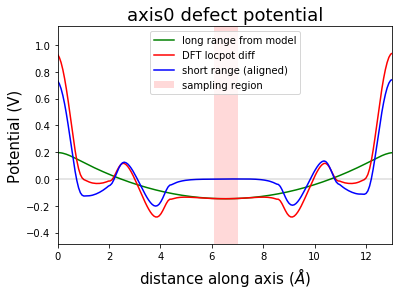

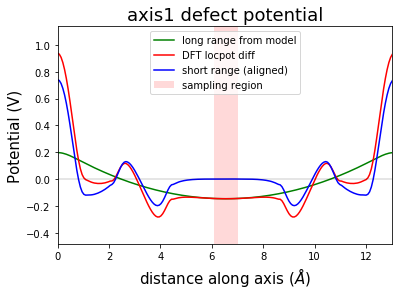

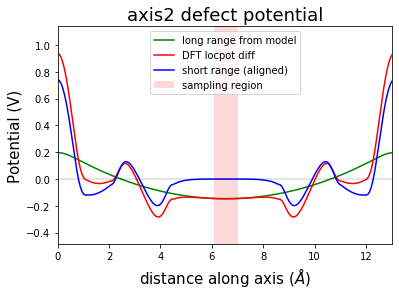

In [3]:
# plot freysoldt potential alignment plot
from DefectsWithTheBoys.pycdt.core.defects_analyzer import freysoldt_correction_from_paths
defect_file_path = "Examples/as_1_Cd_on_te_-2/NUPDOWN_4/"
bulk_file_path = "Examples/Bulk_Supercell/vasp_gam/"
dielectric = 9.13 * np.array([[1., 0, 0], [0., 1., 0], [0, 0, 1.]])
defect_charge = -2

quick_fc = freysoldt_correction_from_paths(defect_file_path, bulk_file_path,
                                           dielectric, defect_charge, plot=True)  # set to True if correction plot printing is desired

# note that you can do the same with kumagai_correction_from_paths (if you have the right OUTCARs)

### Note that we can also create defect complexes
`PyCDT` can't automatically do this, but it's actually relatively simple, depending on what exactly you want to do.
Using the Cd vacancy defect, let's auto-generate all the possible defect complexes of this with another vacancy or a Te interstitial:

In [11]:
vacancies_only['vacancies'][0]['unique_site']  # This is the vacancy site

PeriodicSite: Cd (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]

In [18]:
cd_vac_structure = vacancies_only['vacancies'][0]['supercell']['structure'].copy(
)
def_complex_structs = ChargedDefectsStructures(
    cd_vac_structure,
    cellmax=cd_vac_structure.num_sites,
    # max_min_oxi for bulk elements only unfortunately
    antisites_flag=False, max_min_oxi=None,
    include_interstitials=True, interstitial_elements=['Te'])

Setting up defects...
Searching for Voronoi interstitial sites (this can take awhile)...

Number of jobs created:
    bulk = 1
    vacancies:
        vac_1_Cd = 5 with site multiplicity 3
        vac_2_Cd = 5 with site multiplicity 3
        vac_3_Cd = 5 with site multiplicity 1
        vac_4_Cd = 5 with site multiplicity 12
        vac_5_Cd = 5 with site multiplicity 12
        vac_6_Te = 5 with site multiplicity 12
        vac_7_Te = 5 with site multiplicity 4
        vac_8_Te = 5 with site multiplicity 12
        vac_9_Te = 5 with site multiplicity 4
    substitutions:
    interstitials:
        Int_Te_1 = 9 with site multiplicity 12
        Int_Te_2 = 9 with site multiplicity 24
        Int_Te_3 = 9 with site multiplicity 24
        Int_Te_4 = 9 with site multiplicity 6
        Int_Te_5 = 9 with site multiplicity 12
        Int_Te_6 = 9 with site multiplicity 4
        Int_Te_7 = 9 with site multiplicity 12
        Int_Te_8 = 9 with site multiplicity 12
        Int_Te_9 = 9 with si

In [19]:
# Let's rename the defects so we know that they're complexes: (and print the defect separation)
for i in def_complex_structs.defects['interstitials']:
    i['V_Cd - Interstitial Distance (Angstrom)'] = i['unique_site'].distance(
        vacancies_only['vacancies'][0]['unique_site'])
    i['name'] = 'V_Cd-' + i['name']
sorted_def_complexes = sorted(
    def_complex_structs.defects['interstitials'], key=lambda defect: defect['V_Cd - Interstitial Distance (Angstrom)'])

In [22]:
for i in sorted_def_complexes:
    print(i['name'])
    print(i['bulk_supercell_site'].frac_coords, i['site_specie'])
    print("V_Cd - Interstitial Distance (Angstrom):",
          f"{i['V_Cd - Interstitial Distance (Angstrom)']:.3f}", '\n')

V_Cd-Int_Te_20
[0. 0. 1.] Te
V_Cd - Interstitial Distance (Angstrom): 0.000 

V_Cd-Int_Te_6
[0.10416667 0.89583333 0.89583333] Te
V_Cd - Interstitial Distance (Angstrom): 2.361 

V_Cd-Int_Te_7
[0.0625 0.8125 0.9375] Te
V_Cd - Interstitial Distance (Angstrom): 2.713 

V_Cd-Int_Te_4
[0.75 1.   0.  ] Te
V_Cd - Interstitial Distance (Angstrom): 3.272 

V_Cd-Int_Te_5
[0.6875 0.9375 0.9375] Te
V_Cd - Interstitial Distance (Angstrom): 4.250 

V_Cd-Int_Te_10
[0.1875 0.8125 0.8125] Te
V_Cd - Interstitial Distance (Angstrom): 4.250 

V_Cd-Int_Te_9
[0.6875 0.1875 0.1875] Te
V_Cd - Interstitial Distance (Angstrom): 5.363 

V_Cd-Int_Te_8
[0.625 0.125 0.125] Te
V_Cd - Interstitial Distance (Angstrom): 5.425 

V_Cd-Int_Te_11
[0.25 0.75 0.75] Te
V_Cd - Interstitial Distance (Angstrom): 5.667 

V_Cd-Int_Te_19
[0.75 0.25 0.25] Te
V_Cd - Interstitial Distance (Angstrom): 5.667 

V_Cd-Int_Te_13
[0.8125 0.3125 0.6875] Te
V_Cd - Interstitial Distance (Angstrom): 6.283 

V_Cd-Int_Te_2
[0.0625 0.1875 0.5625] 

Choosing which defect complexes you want to investigate, you can then use `vasp_input.prepare_vasp_defect_inputs`, `vasp_input.prepare_vasp_defect_dict`, ` vasp_input.vasp_gam_files` etc. again.
Just one thing to note if/when calculating corrections on defect complexes:

In [ ]:
# We've also added actual_bulk optional argument to SingleDefectParser.get_bulk_gap_data(), in case we're
# looking at defect complexes (so the SingleDefectParser 'bulk' is actually the original point defect,
# with the wrong pmg-computed gap) - provide the path to the actual perfect bulk CdTe, with the correct band gap
#sdp.get_bulk_gap_data(no_MP=True, actual_bulk_path="Examples/Bulk_Supercell/")

## Chemical Potentials

In [8]:
from DefectsWithTheBoys.pycdt.core.chemical_potentials import UserChemPotInputGenerator
# Note that we've modified setup_phase_diagram_calculations in UserChemPotInputGenerator to also
# print EaH (energy above hull) in name, not print MPID in name, give a dictionary of dictionaries
# (rather than a dictionary of structures etc.)
# Added write_files option to (not) write POSCAR files and folders (better to just generate structures and
# write files ourselves with vasp_converge_files etc)(POSCAR can have wrong ordering - fucks with POTCAR)

# If you are writing the files (to the PhaseDiagram folder), I've added the overwrite option
# to (over)write files even if the PhaseDiagram folder already exists
from pymatgen.core.composition import Composition
cpa = UserChemPotInputGenerator(Composition({'Cd': 1, 'Te': 1}))
cdte_chempot_calcs = cpa.setup_phase_diagram_calculations(energy_above_hull=0.07, full_phase_diagram=False,
                                                          write_files=False, overwrite=False,
                                                          include_elements=True)
# This creates the structures needed for chemical potential calculations, with 0.07 eV of the (MP-calculated)
# energy above hull
# I've added the include_elements option, so that we can use full_phase_diagram = False to only include
# necessary chemical potential calculations (i.e. facets adjacent to the composition of interest in the
# GGA phase diagram, and include_elements = True to include necessary elemental reference energy calculations
# (Not overly important / more efficient than just using full_phase_diagram for CdTe, but for many other
# systems, particularly larger ones (e.g. ternary, quaternary etc. compounds), this is very important)

Returning chempot structures, but ain't making no crap POSCAR files.


In [9]:
for i in cdte_chempot_calcs:
    print(i)

Cd_EaH=0.018
Cd_EaH=0.014
Cd_EaH=0.000
Cd_EaH=0.027
CdTe_EaH=0.004
CdTe_EaH=0.005
CdTe_EaH=0.000
Te_EaH=0.038
Te_EaH=0.042
Te_EaH=0.044
Te_EaH=0.000
Te_EaH=0.041
Te_EaH=0.002
Te_EaH=0.057


**Single-Shot GGA DFT `vasp_std` Convergence Tests**
Recommended to use [vaspup2.0](https://github.com/kavanase/vaspup2.0) - here we'll generate the `input` files

In [15]:
CONFIG = f"""# vaspup2.0 - Seán Kavanagh (sean.kavanagh.19@ucl.ac.uk), 2020
# This is the default config for automating convergence.
# Works for ground-state energy convergence and DFPT convergence.
# Make sure to rename to CONFIG before running.

conv_encut="0"          # No ENCUT convergence testing for chemical potential calcs 
# Use same ENCUT as for defect calculations

conv_kpoint="1"         # 1 for ON, 0 for OFF (KPOINTS Convergence Testing)
kpoints='' # Make with 'kgs_gen_kpts 10 30' (or higher real space cutoff if needs be)

run_vasp="1" # Run VASP after generating the files with 'generate-converge'"""

In [25]:
vasp_input.vasp_converge_files?

Signature:
vasp_input.vasp_converge_files(
    structure,
    input_dir=None,
    incar_settings=None,
    config=None,
)
Docstring:
Generates input files for single-shot GGA convergence test calculations.
Automatically sets ISMEAR (in INCAR) to 2 (if metallic) or 0 if not.
Recommended to use with vaspup2.0
Args:
    structure (Structure object):
        Structure to create input files for
    input_dir (str):
        Folder in which to create 'input' folder with VASP input files
        (default: None)
    incar_settings (dict):
        Dictionary of user INCAR settings (AEXX, NCORE etc.) to override default settings.
        Highly recommended to look at output INCARs or DefectsWithTheBoys.vasp_input
        source code, to see what the default INCAR settings are.
        (default: None)
    config (str):
        CONFIG file string. If provided, will also write the CONFIG file to each 'input' directory
        (default: None)
File:      ~/OneDrive - Imperial College London/Bread/Proj

In [22]:
for key, val in cdte_chempot_calcs.items():
    vasp_input.vasp_converge_files(
        val['Structure'], input_dir='PhaseDiagram/'+key)

Have a look at the auto-generated files in the `PhaseDiagram` folder!

In [26]:
for key, val in cdte_chempot_calcs.items():
    vasp_input.vasp_converge_files(
        val['Structure'], input_dir='PhaseDiagram/'+key, config=CONFIG)
# Use this if you also want to write the CONFIG files to each 'input' directory, ready to go with vaspup2.0

After generating the input files like this, can then use `vaspup2.0` (via the `input/CONFIG` file) to set the range of `ENCUT` and `KPOINTS` you want to check for convergence.